# Peak search methods

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from speparser import Spectrum, SpectrumReader

In [2]:
# spectrum for testing
SPE_PATH = "Eu152.spe"
spe = SpectrumReader().parse_spe(SPE_PATH)
# peaks from spectraline for compare
peaks_from_sl = [316, 358, 368, 470, 963, 1934, 1989, 2143, 2177, 2339, 2568, 2604, 2722, 2909, 3252, 3290, 3513, 3868, 3984, 4045, 4465, 4643, 5201, 5344, 5375, 5455, 5646, 5698, 6060, 6092, 6171, 6421, 6669, 6872, 7284, 7338, 7638, 7964, 8603, 8634, 8812, 9611, 9904, 10244, 10295, 11158, 11551, 11576, 12113, 13984]
len(spe.data)

16384

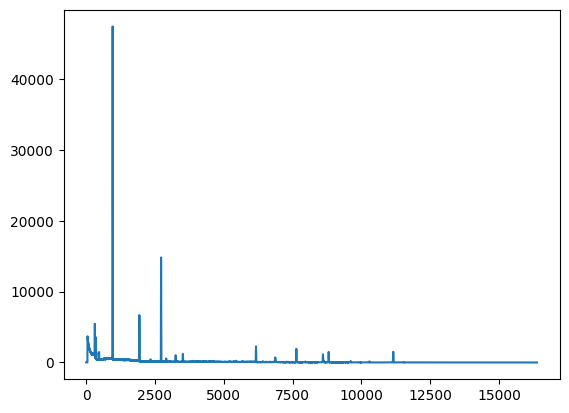

In [3]:
plt.plot(spe.data)

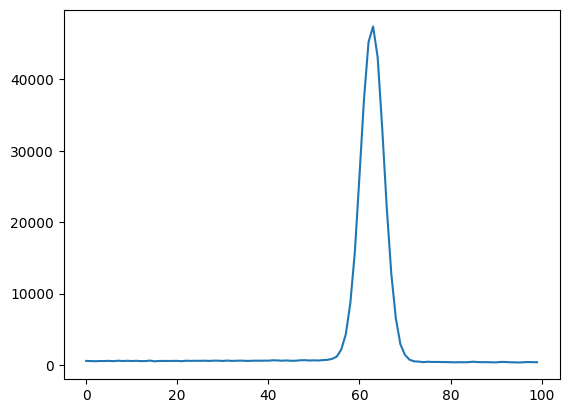

In [4]:
# one peak window
plt.plot(spe.data[900:1000])

### Mariscotti

Mariscotti (M.A. Mariscotti, Nucl. Instrum. Method 50(1967) 309) used the 2nd derivative (SD):
$$
SD[i] = \sum_{k=-1}^{1}{c[k] * N[i+k]}
$$
where:
$$
c[-1] = -1.0; c[0] = 2.0; c[1] = -1.0
$$
`N[i+k]` -- counts at i+k channel.
Also they added smothing effect and replaced SD[i] with the average of m neighbour SD[i]:
$$
SD[i, m] = \sum_{k=-m}^{m}{SD[i+k]}
$$
Furthermore, Mariscotti repeated the above averaging process 5 times.

For the peak criteria, we need also the standard deviation (SSD):
$$
SSD[i] = \sum_{k=-1}^{1}{c[k]^2 * N[i+k]}
$$
$$
SSD[i, m] = \sqrt{\sum_{k=-m}^{m}{SSD[i+k]}}
$$
And ratio SD/SSD we can compare with threshold:
$$
SS[i, m] = \frac{SD[i,m]}{SSD[i,m]} >= threshold
$$
They recomended threshold=3.5.

`m` should be less than peak width: $m < \sigma$, I think it should be 5 times smaller (because of averaging), so  I suppose `m` is in range FWHM/20 -- FWHM/10

In [5]:
# the second derivative can be calclulated as convolution with kernel = [-1.0, 2.0, -1.0]. We use 'same' mode to have same channels number in sd as in the spectrum data.
sd = np.convolve(spe.data, [-1.0, 2.0, -1.0], 'same')

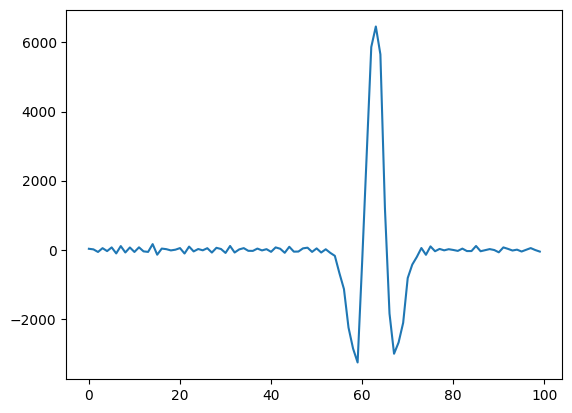

In [6]:
# second derivative (window for the first peak)
plt.plot(sd[900:1000])

In [7]:
# average can be calculated as the convolution with kernel = [1.0, 1.0, ..., 1.0] with len = 2*m+1
# it seems M should ~ FWHM/20 - FWHM/10
M = 2
sdm = np.convolve(sd, np.ones(2*M+1), 'same')

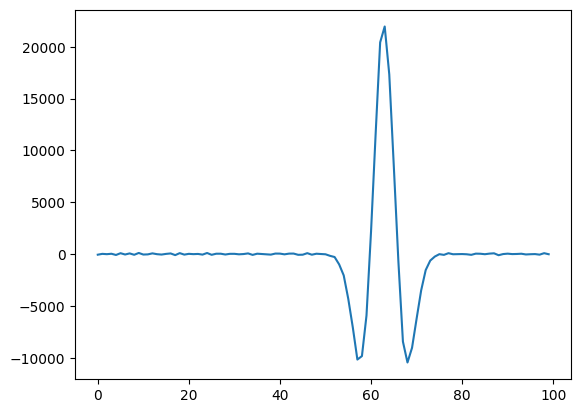

In [8]:
# average second derivative (window for the first peak)
plt.plot(sdm[900:1000])

In [9]:
# the second derivative standard deviation can be calclulated as convolution with kernel = [1.0, 4.0, 1.0].
ssd2 = np.convolve(spe.data, [1.0, 4.0, 1.0], 'same')
ssd = np.sqrt(ssd2)
ssdm2 = np.convolve(ssd2, np.ones(2*M+1), 'same')
ssdm = np.sqrt(ssdm2)

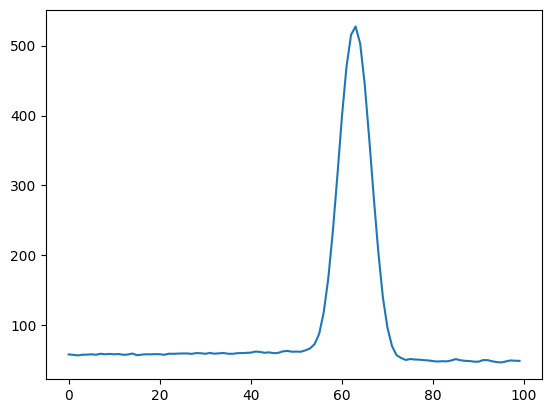

In [10]:
# the second derivative std (window for the first peak)
plt.plot(ssd[900:1000])

In [11]:
# ratio
EPSILON = 1e-8  # not to fail if ssd == 0
ss = sd / (ssd + EPSILON)
ssm = sdm / (ssdm + EPSILON)

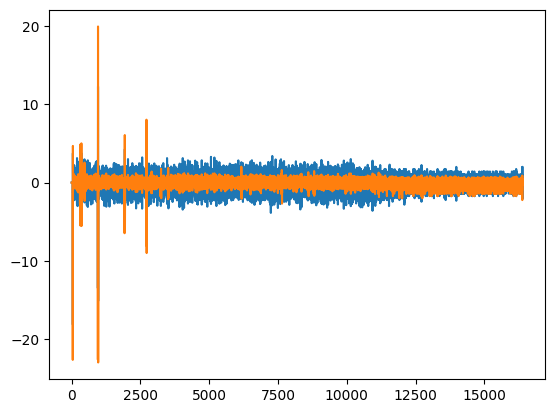

In [12]:
plt.plot(ss)
plt.plot(ssm)

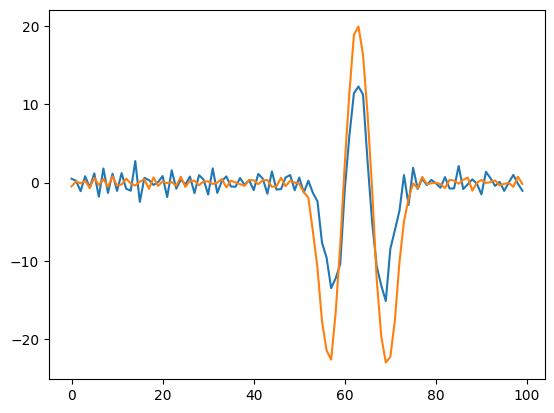

In [13]:
plt.plot(ss[900:1000])
plt.plot(ssm[900:1000])

In [14]:
EPSILON = 1e-8

def find_peaks(data: np.ndarray, threshold: float, x_window: int):
    """
    Common function for peak search using calculated criteria and threshold
    :param data: calculated criteria (can be the 2nd derivative divided by std
    :param threshold: number of sigma
    :param x_window: window, where combine maximums (non maximum suppression)
    """
    peaks = []
    criteria = []
    for i in range(1, len(data)-1):
        if data[i] >= threshold and data[i-1] <= data[i] and data[i] >= data[i+1]:  # peak is found in current position
            if peaks and i - peaks[-1] <= x_window:  # non-maximum suppression
                if data[i] > criteria[-1]:
                    peaks[-1] = i
                    criteria[-1] = data[i]
            else:
                peaks.append(i)
                criteria.append(data[i])
    return peaks, criteria

def mariscotti_peak_search(sp: np.ndarray, m: int, threshold: float, ave_count: int = 5):
    """
    peak search by Mariscotti method
    :param sp: spectrum
    :param m: average area +/-m
    :param threshold: number of sigma
    :param ave_count: number of average runs (5 in the article)
    """
    sd = np.convolve(sp, [-1.0, 2.0, -1.0], 'same')
    ssd2 = np.convolve(sp, [1.0, 4.0, 1.0], 'same')
    ssd = np.sqrt(ssd2)
    # ss = sd / (ssd + EPSILON)
    ave_kernel = np.ones(2*m+1)
    sdm = sd.copy()
    ssdm2 = ssd2.copy()
    for _ in range(ave_count):
        sdm = np.convolve(sdm, ave_kernel, 'same')
        ssdm2 = np.convolve(ssdm2, ave_kernel, 'same')
    ssdm = np.sqrt(ssdm2)
    ssm = sdm / (ssdm + EPSILON)
    return find_peaks(ssm, threshold, m)

In [15]:
peaks_m, criteria_m = mariscotti_peak_search(spe.data, m=3, threshold=2.4, ave_count=5)
print(f'mariscotti peak search, found {len(peaks_m)} peaks')
for p, c in zip(peaks_m, criteria_m):
    print(p, c)

mariscotti peak search, found 47 peaks
53 42.20333537576986
316 68.94161473115855
358 48.58721278493001
470 30.944023580975983
963 274.5594179439746
1934 99.03425935967441
1989 3.0045098305385736
2144 3.8020206253202304
2340 16.078729715777186
2492 2.4058270853429446
2568 2.6534374783838
2604 5.534251185808714
2723 146.15745103693308
2909 21.323043369159528
3252 34.47881654108203
3291 3.4322647878276666
3513 38.71219770592489
3868 10.049552320016149
3984 4.012745402985371
4465 7.164375266837324
4643 7.51682913413327
5201 2.9634156562050795
5344 4.320048002142984
5375 7.644767608100119
5455 10.932491798515114
5646 3.067527165389981
5699 5.124730620444491
6060 2.9970647159874018
6092 2.9026928320569856
6171 48.652424614512526
6421 4.152730438818501
6872 23.389214960015018
7284 4.832628583551175
7338 3.792552089960494
7638 41.14689273414835
7964 7.335646396768871
8603 30.64282317629752
8634 11.299988695578552
8812 34.498976224098676
9612 8.872326476061321
9905 2.5000513341403736
10294 10.

In [16]:
# analyze peak search results (compare them to sl results)
def ch_equal(lhs, rhs, thres=5):
    return abs(lhs - rhs) <= thres

def peaks_compare(peaks, peaks_exp):
    i = 0
    j = 0
    left_unique = []
    right_unique = []
    while i < len(peaks) and j < len(peaks_exp):
        if ch_equal(peaks[i], peaks_exp[j]):
            i += 1
            j += 1
        elif peaks[i] < peaks_exp[j]:
            left_unique.append(peaks[i])
            i += 1
        else:
            right_unique.append(peaks_exp[j])
            j += 1
    while i < len(peaks):
        left_unique.append(peaks[i])
        i += 1
    while j < len(peaks_exp):
        right_unique.append(peaks_exp[j])
        j += 1
    return left_unique, right_unique

In [17]:
peaks_compare(peaks_m, peaks_from_sl) 

([53, 2492], [368, 2177, 4045, 6669, 10244])

### Phillips-Marlow's peak search method

Phillips-Marlow's peak search method (G.W. Phillips and K.W. Marlow, IEEE Transactions on Nuclear Science 24 (1977) 154) is an extension of Mariscotti method. It doesn't need to perform the repeated averaging process.

$$
SD[i, m] = \sum_{k=-m}^{m}{c[k] * N[i+k]}
$$
$$
SSD[i, m] = \sqrt{\sum_{k=-m}^{m}{c[k]^2 * N[i+k]}}
$$
where `m = 2*w+1`, `w` -- width, should be close to $\sigma$
```
c[k] = -1 for k = -m to -(w+1)
        2 for k = -w to w
       -1 for k=(w+1) to m
```

### Robertson et al’s peak search method

Robertson et al’s peak search method (A. Robertson, W.V. Prestwich and T.J. Kennett, Nucl. Instrum. Methods 100 (1972) 317) is based on Phillips-Marlow’s peak search method.

$$
SD[i, m] = \sum_{k=-m}^{m}{c[k] * N[i+k]}
$$
$$
SSD[i, m] = \sqrt{\sum_{k=-m}^{m}{c[k]^2 * N[i+k]}}
$$
where `m = 5*w+1`, `w` -- width, should be close to $\sigma$ (~FWHM/2)
```
c[k] = -1 for k = -m to -(w+1)
        4 for k = -w to w
       -1 for k=(w+1) to m
```

In [18]:
def _peak_search_with_kernel(sp: np.ndarray, w: int, m: int, threshold: float, kernel: np.ndarray):
    """generalized peak search function -- searches peaks with given kernel"""
    sd = np.convolve(sp, kernel, 'same')
    ssd2 = np.convolve(sp, kernel**2, 'same')
    ssd = np.sqrt(ssd2)
    ss = sd / (ssd + EPSILON)
    return find_peaks(ss, threshold, m)

def phillips_marlow_peak_search(sp: np.ndarray, w: int, threshold: float):
    """
        peak search by Phillips and Marlow method
        :param sp: spectrum
        :param w: peak width ~ FWHM/2
        :param threshold: number of sigma
    """
    m = 2*w+1
    kernel = np.array(
        [2 if -w <= i-m <= w else -1 for i in range(2*m+1)]
    )
    return _peak_search_with_kernel(sp, w, m, threshold, kernel)
    
def robertson_peak_search(sp: np.ndarray, w: int, threshold: float):
    """
        peak search by Phillips and Marlow method
        :param sp: spectrum
        :param w: peak width ~ FWHM/2
        :param threshold: number of sigma
    """
    m = 5*w+1
    kernel = np.array(
        [4 if -w <= i-m <= w else -1 for i in range(2*m+1)]
    )
    return _peak_search_with_kernel(sp, w, m, threshold, kernel)

In [19]:
peaks_r, criteria_r = robertson_peak_search(spe.data, w=5, threshold=6.0)
print(f'robertson peak search, found {len(peaks_r)} peaks')
for p, c in zip(peaks_r, criteria_r):
    print(p, c)

robertson peak search, found 55 peaks
54 107.18154974839901
127 6.22567404398123
231 6.2882435945933555
315 153.52452489923124
359 102.64709301295328
470 58.72080272710788
594 6.649737425144918
672 9.113263264526134
763 6.64250653923987
963 529.7194087558993
1934 206.06812634993761
1989 8.406650666046605
2142 9.292768506591498
2177 6.112039256392908
2340 34.92290739303237
2493 6.199430521368099
2568 6.935913092483916
2604 12.856648165884256
2723 319.10004439747246
2909 48.09110830464228
3252 78.41228432004314
3291 9.659589069052812
3513 88.189749548874
3868 23.997829422251495
3984 11.015173433163344
4046 6.282400566907784
4465 17.92971969074132
4642 18.51548676808745
5200 8.52037495736005
5343 10.434983894291948
5376 19.385144629635068
5455 28.45874784474852
5647 8.63726153593191
5699 13.828207617993174
6059 9.187726664394173
6094 6.971469013751515
6171 126.07040936320132
6420 12.443340266969823
6668 7.810559006527662
6872 62.20380683099797
7285 14.748530332811423
7337 10.7687924168063

In [20]:
peaks_compare(peaks_r, peaks_from_sl) 

([54, 127, 231, 594, 672, 763, 2493], [368, 10244])

### Block's peak search method

Block's peak search method (H.P. Blok, J.C. De Lange and J.W. Schotman, Nucl. Instrum. Methods 128 (1975) 545) and (L. Loska and J. Janczyszyn, Appl. Radiat. Isot. 48 (1997) 127) is based on statistical correlations between the shape of a peak in the spectrum and an assumed peak shape. It checks how well a certain peak shape (gaussian) fits the interesting part of the spectrum.

Using least-squares formula for $N_{i+k} = h_i * c_j + b_i$ leads to expressions:

Peak's height:
$$
h[i, m] = \sum_{k=-m}^{m} {g_k * \sum_{k=-m}^{m}{g_k c_k N[i+k]}} - \sum_{k=-m}^{m} {g_k c_k * \sum_{k=-m}^{m}{g_k N[i+k]}}
$$
std of peak's height (*it seems to be an error in formula, std h must be ~ sqrt(N), and there is no dependency on N*):
$$
\Delta h[i, m] = \sqrt{ \sum_{k=-m}^{m} {g_k * [\sum_{k=-m}^{m}{g_k c_k^2} \sum_{k=-m}^{m} {g_k} - (\sum_{k=-m}^{m} {g_k c_k})^2]} }
$$
where
$$
c_k = exp(-2.773 * (\frac{k}{FWHM})^2)
$$
$$
g_k = exp(-2.0 * (\frac{k}{FWHM})^4)
$$
```
m = int(1.1 * FWHM)
```

And then calculate criteria:
$$
R[i,m] = \frac{h[i,m]}{\Delta h[i,m]}
$$
`R` is compared with threshold (~2)

In [21]:
def block_peak_search(sp: np.ndarray, fwhm: float, threshold: float = 2):
    assert fwhm > 0
    m = int(1.1 * fwhm)
    n = 2*m+1
    ck = lambda k: np.exp(-2.773 * (k / fwhm)**2)
    gk = lambda k: np.exp(-2.0 * (k / fwhm)**4)
    kernel_g = np.array([gk(k-m) for k in range(n)])
    kernel_gc = np.array([gk(k-m)*ck(k-m) for k in range(n)])
    kernel_gc2 = np.array([gk(k-m)*ck(k-m)**2 for k in range(n)])
    h_m = kernel_g.sum() * np.convolve(sp, kernel_gc, 'same') - kernel_gc.sum() * np.convolve(sp, kernel_g, 'same')
    dh_m = kernel_g.sum() * (kernel_gc2.sum() * kernel_g.sum() - kernel_gc.sum()**2)
    dh_m = np.sqrt(dh_m)
    
    r_m = h_m / (dh_m + EPSILON)
    return find_peaks(r_m, threshold, m)

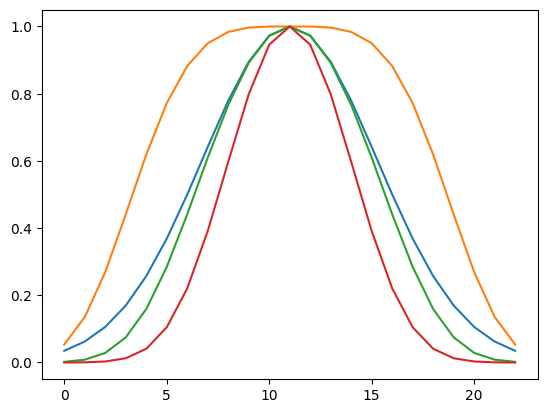

In [22]:
# just for images
fwhm = 10
m = int(1.1 * fwhm)
n = 2*m+1
ck = lambda k: np.exp(-2.773 * (k / fwhm)**2)
gk = lambda k: np.exp(-2.0 * (k / fwhm)**4)
kernel_c = np.array([ck(k-m) for k in range(n)])
kernel_g = np.array([gk(k-m) for k in range(n)])
kernel_gc = np.array([gk(k-m)*ck(k-m) for k in range(n)])
kernel_gc2 = np.array([gk(k-m)*ck(k-m)**2 for k in range(n)])
plt.plot(kernel_c)
plt.plot(kernel_g)
plt.plot(kernel_gc)
plt.plot(kernel_gc2)

In [23]:
peaks_b, criteria_b = block_peak_search(spe.data, fwhm=10, threshold=2.0)
print(f'block peak search, found {len(peaks_b)} peaks')
for p, c in zip(peaks_b, criteria_b):
    print(p, c)

block peak search, found 537 peaks
52 3173.07129451131
77 25.09425358357188
98 25.024348098713922
110 45.062515996268914
126 51.853410633644465
151 6.942349643232233
165 54.802065878999365
188 63.87293667368785
206 87.53366893432266
230 68.78916770804749
252 31.690253171459826
273 29.088307106268662
288 28.821976126010792
316 5646.480180809263
339 82.39916685959078
358 3393.3928066771955
370 172.4354178096143
384 39.54088061722949
404 20.36749422900541
427 23.14259348540665
447 14.83797889347092
470 1386.472460062495
493 13.22221818196348
519 18.196706888403828
533 16.469904816538858
555 14.322084733319063
576 37.351778905286295
593 78.41905213453704
608 23.890491749326237
657 28.838930092803444
673 55.819116803430866
690 32.895213148055106
721 15.587807792843767
733 32.509375854990765
758 28.657090433369245
770 22.38853391548434
786 22.215969706544257
808 19.863215674167886
824 46.43784236272433
845 12.60694268083976
861 28.204369711131488
885 31.454760159638724
909 23.314852451560455

In [24]:
peaks_compare(peaks_b, peaks_from_sl) 

([52,
  77,
  98,
  110,
  126,
  151,
  165,
  188,
  206,
  230,
  252,
  273,
  288,
  339,
  384,
  404,
  427,
  447,
  493,
  519,
  533,
  555,
  576,
  593,
  608,
  657,
  673,
  690,
  721,
  733,
  758,
  770,
  786,
  808,
  824,
  845,
  861,
  885,
  909,
  927,
  940,
  987,
  1001,
  1026,
  1045,
  1068,
  1099,
  1121,
  1139,
  1154,
  1170,
  1183,
  1203,
  1218,
  1230,
  1250,
  1264,
  1278,
  1309,
  1322,
  1336,
  1348,
  1373,
  1387,
  1416,
  1430,
  1444,
  1472,
  1493,
  1520,
  1533,
  1546,
  1565,
  1578,
  1608,
  1629,
  1641,
  1658,
  1680,
  1705,
  1721,
  1734,
  1752,
  1770,
  1794,
  1809,
  1831,
  1843,
  1857,
  1873,
  1888,
  1909,
  1957,
  1975,
  2009,
  2023,
  2048,
  2063,
  2118,
  2130,
  2160,
  2219,
  2232,
  2246,
  2259,
  2271,
  2284,
  2297,
  2312,
  2373,
  2396,
  2427,
  2445,
  2463,
  2475,
  2492,
  2506,
  2521,
  2534,
  2583,
  2628,
  2645,
  2668,
  2692,
  2747,
  2769,
  2783,
  2820,
  2834,
  2848,
  286